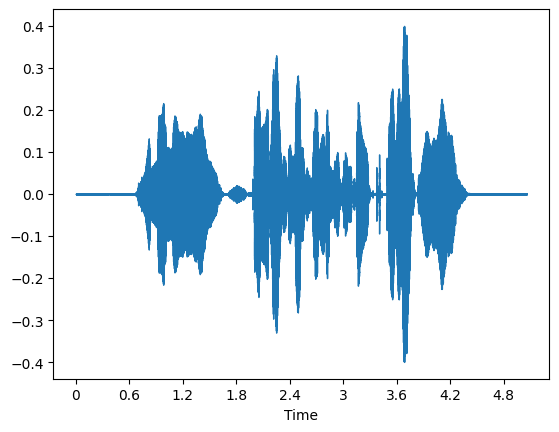

In [1]:
import librosa
import matplotlib.pyplot as plt

f = 'mnt/gcs-bucket/data/F2001/F2001_000001.wav'
y, sr = librosa.load(f)

librosa.display.waveshow(y, sr=sr)

In [2]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
    print(f"GPU device name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

GPU is available
GPU device name: Tesla T4


In [3]:
import torch

print(f"Available GPUs: {torch.cuda.device_count()}")
print(f"Current GPU: {torch.cuda.current_device()}")
print(f"GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")


Available GPUs: 4
Current GPU: 0
GPU Name: Tesla T4


In [10]:
import os
import torch
import soundfile as sf
import librosa
import pandas as pd
from transformers import HubertForSequenceClassification, Wav2Vec2Processor, Trainer, TrainingArguments
from transformers import HubertForSequenceClassification, Wav2Vec2FeatureExtractor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings


# Helper function to split dataset into smaller batches
def split_dataset(dataset, num_splits):
    split_size = len(dataset) // num_splits
    splits = [torch.utils.data.Subset(dataset, list(range(i * split_size, (i + 1) * split_size))) for i in range(num_splits)]
    remainder = len(dataset) % num_splits
    if remainder:
        splits[-1] = torch.utils.data.ConcatDataset([splits[-1], torch.utils.data.Subset(dataset, list(range(num_splits * split_size, len(dataset))))])
    return splits

torch.cuda.empty_cache()

# 1. CSV 파일 로드 및 전처리 (None 값 제거)
csv_file_path = '/home/mywinningtime/labeling.csv'
df = pd.read_csv(csv_file_path).dropna(subset=['감정'])  # None 값 제거

# 감정 레이블 정의 및 매핑
emotion_labels = df['감정'].unique().tolist()
label2id = {str(emotion): int(i) for i, emotion in enumerate(emotion_labels)}
id2label = {int(i): str(emotion) for i, emotion in enumerate(emotion_labels)}

# 2. 음성 파일 로드 함수 정의
def load_audio(file_path):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    speech, rate = sf.read(file_path)
    if rate != 16000:  # 16000Hz로 리샘플링
        speech = librosa.resample(speech, orig_sr=rate, target_sr=16000)
    return speech

# 3. SpeechDataset 클래스 정의
class SpeechDataset(Dataset):
    def __init__(self, df, base_directory, folders):
        self.base_directory = base_directory
        self.folders = folders

        # 모든 폴더를 탐색하며 CSV 파일 정보와 매칭
        self.data = []
        for folder_name in folders:
            folder_path = os.path.join(base_directory, folder_name)
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".wav"):
                    # 파일명에서 숫자 부분 추출 (예: M2001_000001.wav -> 000001)
                    file_number = int(file_name.split('_')[-1].replace(".wav", ""))
                    
                    # CSV 파일에서 '연번' 열과 일치하는 행 찾기
                    matching_rows = df[df['연번'] == file_number]
                    if not matching_rows.empty:
                        emotion = matching_rows.iloc[0]['감정']
                        label = label2id[emotion]
                        
                        # 데이터 리스트에 경로와 레이블 추가
                        self.data.append({
                            'file_path': os.path.join(folder_path, file_name),
                            'label': label
                        })

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 파일 경로와 레이블 가져오기
        file_path = self.data[idx]['file_path']
        label = self.data[idx]['label']

        # 음성 파일 로드 및 전처리
        speech = load_audio(file_path)
        inputs = feature_extractor(speech, sampling_rate=16000, return_tensors="pt", padding=True)

        return {
            "input_values": inputs.input_values[0],
            "attention_mask": inputs.attention_mask[0] if "attention_mask" in inputs else None,
            "labels": torch.tensor(label, dtype=torch.long),
        }

# 4. collate_fn 정의: 배치 생성 시 입력을 동일한 길이로 패딩
def collate_fn(batch):
    input_values = [item["input_values"] for item in batch]
    labels = torch.tensor([item["labels"] for item in batch], dtype=torch.long)
    input_values_padded = pad_sequence(input_values, batch_first=True, padding_value=0.0)
    attention_mask = (input_values_padded != 0).long()

    return {
        "input_values": input_values_padded,
        "attention_mask": attention_mask,
        "labels": labels,
    }

# 5. 평가 메트릭 함수 정의
def compute_metrics(pred):
    # predictions가 튜플로 반환되면 첫 번째 요소(logits)만 사용
    logits = pred.predictions[0] if isinstance(pred.predictions, tuple) else pred.predictions
    preds = logits.argmax(-1)  # 가장 높은 로짓 값의 인덱스가 예측 값
    acc = accuracy_score(pred.label_ids, preds)  # 정확도 계산
    return {"accuracy": acc}
    
# 6. 데이터셋 및 DataLoader 준비
audio_directory = "mnt/gcs-bucket/data/"

# 모든 M으로 시작하는 폴더 가져오기
def get_folders_with_prefix(base_directory, prefix="M"):
    folders = [
        folder for folder in os.listdir(base_directory) 
        if os.path.isdir(os.path.join(base_directory, folder)) and folder.startswith(prefix)
    ]
    return sorted(folders)  # 정렬된 순서로 반환

all_folders = get_folders_with_prefix(audio_directory)

# Train/Test 분할 (80%: Train, 20%: Test)
train_folders, test_folders = train_test_split(all_folders, test_size=0.2, random_state=42)

train_dataset = SpeechDataset(df, audio_directory, train_folders)
test_dataset = SpeechDataset(df, audio_directory, test_folders)

# Train/Test 데이터셋을 24개로 분할
train_subsets = split_dataset(train_dataset, 36)
test_subsets = split_dataset(test_dataset, 36)

# 각 Train/Test 서브셋에 대해 학습 및 평가 진행
for i, (train_subset, test_subset) in enumerate(zip(train_subsets, test_subsets)):
    warnings.filterwarnings("ignore")  # 모든 경고 숨기기
    torch.cuda.empty_cache()
    print(f"Training on subset {i + 1}/36")
    train_loader = DataLoader(train_subset, batch_size=8, collate_fn=collate_fn, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=8, collate_fn=collate_fn)

    # 모델 및 프로세서 설정 (hubert-base-superb-er 사용)
    model = HubertForSequenceClassification.from_pretrained(
        "superb/hubert-base-superb-er",
        num_labels=len(emotion_labels),  # 6개 클래스 (현재 CSV의 클래스 개수에 맞춰 조정)
        label2id=label2id,
        id2label=id2label,
        problem_type="single_label_classification",
        ignore_mismatched_sizes=True  # 크기 불일치 무시
    )

    feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("superb/hubert-base-superb-er")

    # 훈련 설정
    training_args = TrainingArguments(
        output_dir=f"./results/subset_{i+1}",
        evaluation_strategy="epoch",
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=8,  # 배치 크기 조정
        per_device_eval_batch_size=8,
        num_train_epochs=3,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        greater_is_better=True,
        gradient_accumulation_steps=1,  # 그라디언트 누적 단계 설정 감소
        fp16=True 
    )

    # Trainer 설정
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_subset,
        eval_dataset=test_subset,
        tokenizer=feature_extractor,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
    )

    # 모델 학습
    trainer.train()

    # 테스트 평가
    results = trainer.evaluate()
    print(f"Test Results for subset {i + 1}: {results}")

/home/mywinningtime/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on subset 1/36


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.778047,0.270588
2,No log,1.765542,0.241176
3,No log,1.761914,0.241176


Test Results for subset 1: {'eval_loss': 1.778046727180481, 'eval_accuracy': 0.27058823529411763, 'eval_runtime': 7.7562, 'eval_samples_per_second': 21.918, 'eval_steps_per_second': 0.774, 'epoch': 3.0}
Training on subset 2/36


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.771439,0.235294
2,No log,1.765779,0.288235
3,No log,1.759145,0.270588


Test Results for subset 2: {'eval_loss': 1.7657790184020996, 'eval_accuracy': 0.28823529411764703, 'eval_runtime': 6.5331, 'eval_samples_per_second': 26.021, 'eval_steps_per_second': 0.918, 'epoch': 3.0}
Training on subset 3/36


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.778602,0.170588


OutOfMemoryError: CUDA out of memory. Tried to allocate 374.00 MiB. GPU 0 has a total capacity of 14.57 GiB of which 168.75 MiB is free. Including non-PyTorch memory, this process has 14.40 GiB memory in use. Of the allocated memory 9.86 GiB is allocated by PyTorch, and 4.33 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [5]:
import os
from tqdm import tqdm
import librosa

# 오디오 파일이 있는 디렉터리 경로
audio_directory = "mnt/gcs-bucket/data/"

# 주어진 접두어로 시작하는 폴더를 가져오는 함수
def get_folders_with_prefix(base_directory, prefix="M"):
    folders = [
        folder for folder in os.listdir(base_directory) 
        if os.path.isdir(os.path.join(base_directory, folder)) and folder.startswith(prefix)
    ]
    return sorted(folders)  # 정렬된 순서로 반환

# 모든 M으로 시작하는 폴더 목록 가져오기
all_folders = get_folders_with_prefix(audio_directory)

# 오디오 길이를 저장할 리스트
len_list = []

# 모든 폴더와 파일을 순회하며 길이 계산
for folder_name in tqdm(all_folders):
    folder_path = os.path.join(audio_directory, folder_name)
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            # librosa를 사용해 오디오 로드
            y, s = librosa.load(file_path)
            # 길이 계산 및 리스트에 추가
            len_list.append(len(y) / s)

print("모든 오디오 파일의 길이(초):", len_list)


100%|██████████████████████████████████████████████████████████████████████████████████████| 251/251 [56:09<00:00, 13.42s/it]

모든 오디오 파일의 길이(초): [4.922630385487528, 10.309659863945578, 6.919546485260771, 6.873106575963718, 5.38702947845805, 7.337505668934241, 8.452063492063493, 6.2693877551020405, 10.216780045351474, 6.0836281179138325, 8.730702947845804, 6.594467120181406, 7.058866213151927, 3.9938321995464854, 9.102222222222222, 6.0836281179138325, 8.359183673469389, 6.176507936507937, 6.780226757369615, 6.130068027210885, 11.935056689342403, 8.359183673469389, 4.551111111111111, 6.176507936507937, 6.03718820861678, 9.380861678004536, 5.108390022675737, 7.244625850340136, 8.591383219954649, 8.730702947845804, 5.61922902494331, 8.730702947845804, 7.476825396825397, 5.804988662131519, 6.130068027210885, 7.987664399092971, 10.356099773242631, 3.250793650793651, 9.241541950113378, 5.38702947845805, 4.690430839002268, 8.126984126984127, 9.341496598639456, 7.291065759637188, 9.195102040816327, 3.9938321995464854, 5.479909297052155, 4.922630385487528, 6.176507936507937, 3.6687528344671203, 2.9257142857142857, 4.133

/tmp/ipykernel_12575/2608916104.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(len_list)


<Axes: title={'center': 'Length of audio'}, ylabel='Density'>

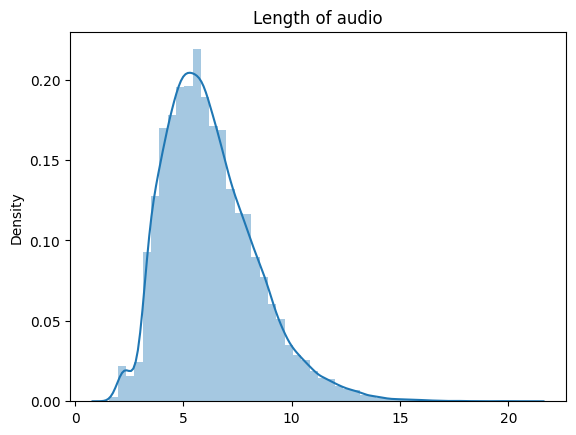

In [9]:
import seaborn as sns

plt.title("Length of audio")
sns.distplot(len_list)

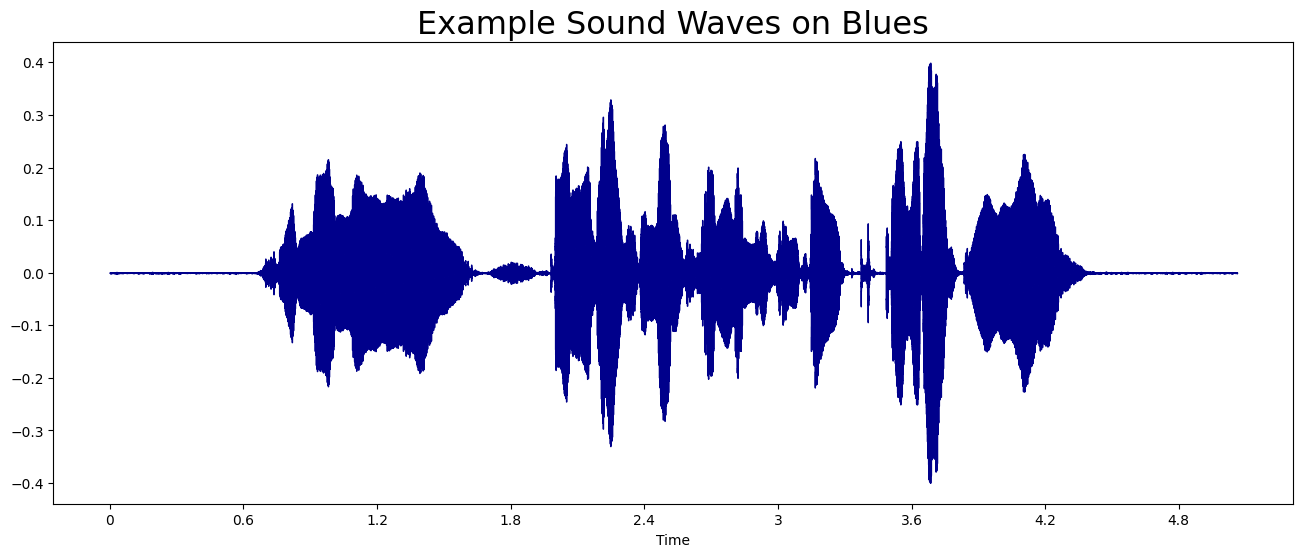

In [10]:
f = 'mnt/gcs-bucket/data/F2001/F2001_000001.wav'
y, sr = librosa.load(f)
audio, _ = librosa.effects.trim(y)

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio, sr = s, color = "#00008B");
plt.title("Example Sound Waves on Blues", fontsize = 23);

In [12]:
import numpy as np

fft = 2048
hl = 512

stft = np.abs(librosa.stft(audio, n_fft = fft, hop_length = hl))

print(np.shape(stft))

(1025, 219)


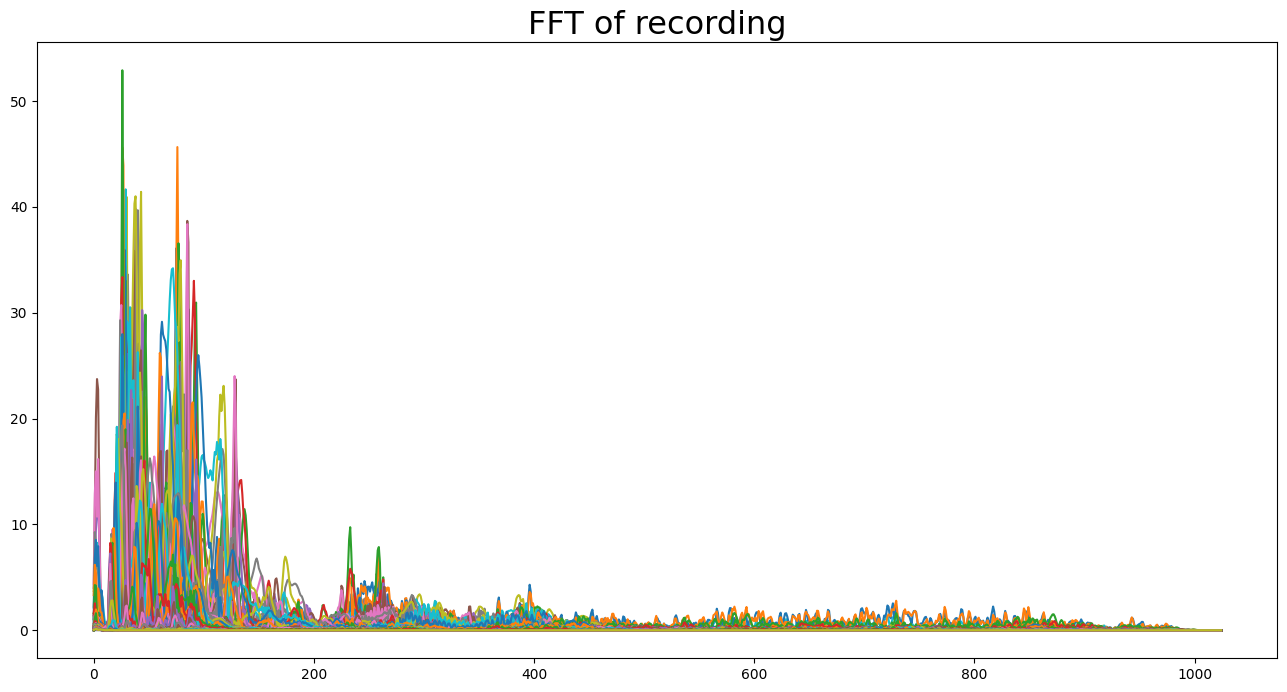

In [13]:
plt.figure(figsize = (16, 8))
plt.title("FFT of recording", fontsize = 23);
plt.plot(stft);

In [ ]:
import os
from tqdm import tqdm
import librosa

# 오디오 파일이 있는 디렉터리 경로
audio_directory = "mnt/gcs-bucket/data/"

# 주어진 접두어로 시작하는 폴더를 가져오는 함수
def get_folders_with_prefix(base_directory, prefix="F"):
    folders = [
        folder for folder in os.listdir(base_directory) 
        if os.path.isdir(os.path.join(base_directory, folder)) and folder.startswith(prefix)
    ]
    return sorted(folders)  # 정렬된 순서로 반환

# 모든 M으로 시작하는 폴더 목록 가져오기
all_folders = get_folders_with_prefix(audio_directory)

# 오디오 길이를 저장할 리스트
len_list = []

# 모든 폴더와 파일을 순회하며 길이 계산
for folder_name in tqdm(all_folders):
    folder_path = os.path.join(audio_directory, folder_name)
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".wav"):
            file_path = os.path.join(folder_path, file_name)
            # librosa를 사용해 오디오 로드
            y, s = librosa.load(file_path)
            # 길이 계산 및 리스트에 추가
            len_list.append(len(y) / s)

plt.title("Length of audio")
sns.distplot(len_list)